# Import Required Libraries

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import IPython.display as Disp
from ipywidgets import widgets
import numpy as np
import cv2
import rasterio
from rasterio.enums import Resampling
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.transform import from_origin
import tifffile

# for json add later
points = []

# Load and visualize a .tif File

In [2]:
# print available tif files
local_directory = os.path.expanduser('~/FIREMAPS/Data/Wildfires')
tif_files = [f for f in os.listdir(local_directory) if f.endswith('.tif')]

for tif in tif_files:
    print(os.path.join(local_directory, tif))

C:\Users\Owner/FIREMAPS/Data/Wildfires\CAPELLA_C09_SP_GEO_HH_20250112071930_20250112071936.tif
C:\Users\Owner/FIREMAPS/Data/Wildfires\CAPELLA_C10_SM_GEO_HH_20250114013943_20250114013952.tif
C:\Users\Owner/FIREMAPS/Data/Wildfires\CAPELLA_C10_SS_GEO_HH_20250113021051_20250113021104.tif
C:\Users\Owner/FIREMAPS/Data/Wildfires\CAPELLA_C11_SP_GEO_HH_20250112202415_20250112202441.tif
C:\Users\Owner/FIREMAPS/Data/Wildfires\CAPELLA_C13_SM_GEO_HH_20250115210818_20250115210823.tif
C:\Users\Owner/FIREMAPS/Data/Wildfires\CAPELLA_C13_SM_GEO_HH_20250116125106_20250116125111.tif
C:\Users\Owner/FIREMAPS/Data/Wildfires\CAPELLA_C13_SM_GEO_HH_20250118200502_20250118200506.tif
C:\Users\Owner/FIREMAPS/Data/Wildfires\CAPELLA_C13_SM_GEO_HH_20250119114748_20250119114753.tif
C:\Users\Owner/FIREMAPS/Data/Wildfires\CAPELLA_C13_SM_GEO_HH_20250119183651_20250119183655.tif
C:\Users\Owner/FIREMAPS/Data/Wildfires\CAPELLA_C14_SS_GEO_HH_20250111145546_20250111145602.tif
C:\Users\Owner/FIREMAPS/Data/Wildfires\CAPELLA_C14

In [3]:
# select tif file to use
tif_input = 'CAPELLA_C13_SM_GEO_HH_20250116125106_20250116125111' # ensure no .tif at end!

(3879, 4049)


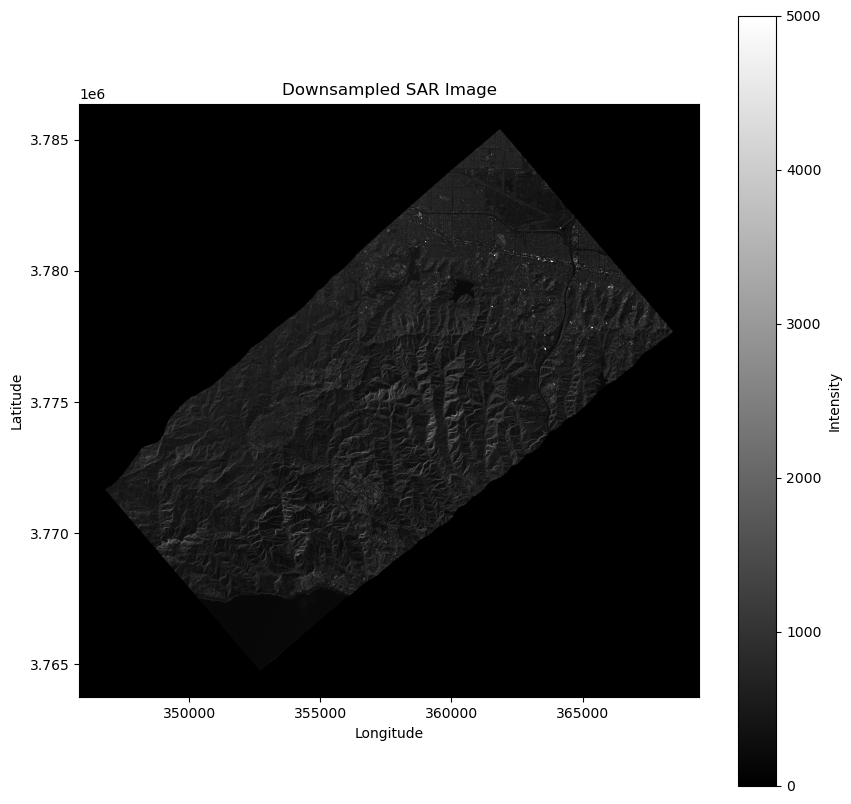

In [4]:
# get a tif and display
tif_filepath = '~/FIREMAPS/Data/Wildfires/' + tif_input + '.tif'
tif_file = os.path.expanduser(tif_filepath)

with rasterio.open(tif_file) as src:
    down_factor = 6  
    new_height = src.height // down_factor
    new_width = src.width // down_factor

    img_data = src.read(
        1,  
        out_shape=(new_height, new_width), 
        resampling=Resampling.average 
    )
    print(np.shape(img_data))

    plt.figure(figsize=(10, 10))
    plt.imshow(img_data, cmap='gray', extent=(src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top),
               vmin = 000, vmax = 5000)
    plt.title("Downsampled SAR Image")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.colorbar(label="Intensity")
    plt.show()

# Chop up data

In [7]:
# setup filepaths for png and tif outputs
tif_file = os.path.expanduser(tif_filepath)
tif_basename = os.path.splitext(os.path.basename(tif_file))[0]
tif_dir = os.path.dirname(tif_file)
output_dir = os.path.join(tif_dir, tif_basename)
output_png_dir = os.path.join(output_dir, "tiles_png")
output_tif_dir = os.path.join(output_dir, "tiles_tif")
os.makedirs(output_png_dir, exist_ok=True)
os.makedirs(output_tif_dir, exist_ok=True)

# open, downsample, transform tif
with rasterio.open(tif_file) as src:
    down_factor = 1   
    new_height = src.height // down_factor
    new_width = src.width // down_factor

    img_data = src.read(
        1,  
        out_shape=(new_height, new_width), 
        resampling=Resampling.average 
    )

    transform = src.transform * src.transform.scale(
        (src.width / new_width),  
        (src.height / new_height)
    )

# ENTER TILE SIZE HERE:
tile_size = 512

# loop and create subsets of tif/png
rows, cols = img_data.shape
tile_idx = 0
for i in range(0, rows, tile_size):
    for j in range(0, cols, tile_size):
        tile = img_data[i:i+tile_size, j:j+tile_size]  

        # only save non-blank tiles
        if tile.shape == (tile_size, tile_size) and np.any(tile > 0):
            vmax = np.percentile(tile, 95)
            
            # PNG
            png_filename = os.path.join(output_png_dir, f"tile_{tile_idx}.png")
            plt.imsave(png_filename, tile, cmap='gray', vmin=0, vmax=vmax)
            
            # TIF
            tile_scaled = np.clip(tile, 0, vmax)
            tile_transform = from_origin(
                transform.c + j * transform.a,  
                transform.f - i * transform.e,  
                transform.a, transform.e
            )

            tif_filename = os.path.join(output_tif_dir, f"tile_{tile_idx}.tif")
            with rasterio.open(
                tif_filename, 'w', 
                driver='GTiff',
                height=tile_size,
                width=tile_size,
                count=1,
                dtype=tile_scaled.dtype,
                crs=src.crs,
                transform=tile_transform
            ) as dst:
                dst.write(tile_scaled, 1)
            
            tile_idx += 1

print(f"Saved {tile_idx} non-empty tiles in {output_dir}")

Saved 242 non-empty tiles in C:\Users\Owner/FIREMAPS/Data/Wildfires\CAPELLA_C13_SM_GEO_HH_20250116125106_20250116125111


# Data Labeling PNG

In [8]:
# https://medium.com/@khandelwalprateek01/how-to-select-roi-in-jupyter-notebook-309fe5185a54
class bbox_select():
    %matplotlib notebook 
    def __init__(self,im):
        self.im = im
        self.selected_points = []
        self.fig,ax = plt.subplots()
        self.img = ax.imshow(self.im.copy())
        self.ka = self.fig.canvas.mpl_connect('button_press_event', self.onclick)
        disconnect_button = widgets.Button(description="Disconnect mpl")
        Disp.display(disconnect_button)
        disconnect_button.on_click(self.disconnect_mpl)     
    def poly_img(self,img,pts):
        pts = np.array(pts, np.int32)
        pts = pts.reshape((-1,1,2))
        cv2.polylines(img,[pts],True,(np.random.randint(0,255),np.random.randint(0,255),np.random.randint(0,255)),7)
        return img
    def onclick(self, event):
        self.selected_points.append([event.xdata,event.ydata])
        if len(self.selected_points)>1:
            self.fig
            self.img.set_data(self.poly_img(self.im.copy(),self.selected_points))
    def disconnect_mpl(self,_):
        self.fig.canvas.mpl_disconnect(self.ka)

Instructions for next cell:
1. manually enter file number of image 
2. select bounding box of burned area by clicking on vertices
3. hit 'disconnect mpl' button and then hit button in top right of image
4. run next cell to add bounding box coords to list
5. run last cell to save as JSON

- repeat steps 3 and 4 if there are multiple regions of interest in the same image, then run step 5 after all regions added to list!

<IPython.core.display.Javascript object>


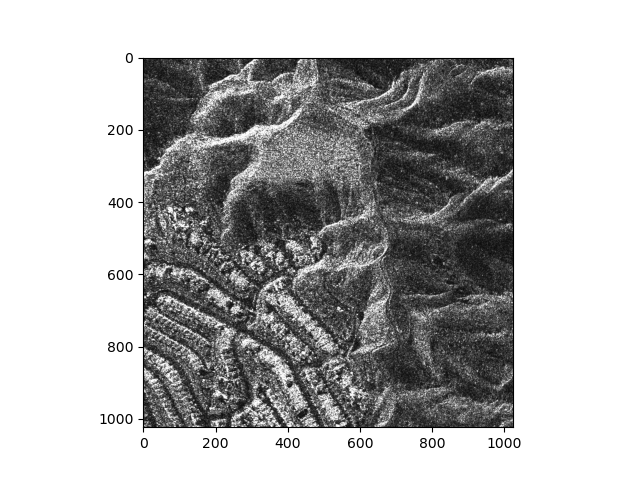

Button(description='Disconnect mpl', style=ButtonStyle())

In [16]:
# ENTER FILE NUM HERE:
file_num = 175

# open as png
filepath_tiles = '~/FIREMAPS/Data/Wildfires/' + tif_input + '/tiles_png/'
filepath_img = '~/FIREMAPS/Data/Wildfires/' + tif_input + '/tiles_png/tile_' + str(file_num) + '.png'
png_file = os.path.expanduser(filepath_img)

with Image.open(png_file) as img:
    img_data = np.array(img)

# call bbox function
bs = bbox_select(img_data)

# option to open as tiff:
#filepath_tiles = os.path.expanduser(f'~/FIREMAPS/Data/Wildfires/{tif_input}/tiles_tif/')
#filepath_img = os.path.expanduser(f'~/FIREMAPS/Data/Wildfires/{tif_input}/tiles_tif/tile_{file_num}.tif')
#img_data = tifffile.imread(filepath_img)
#bs = bbox_select(img_data)

In [15]:
# display selected bounds
points.append(bs.selected_points)
print('selected bounds:')
points

selected bounds:


[[[21.023809523809575, 376.62554112554096],
  [306.391774891775, 492.98917748917734],
  [425.5259740259741, 614.8939393939393],
  [575.1363636363637, 786.668831168831],
  [655.482683982684, 1002.7727272727273],
  [7.170995670995751, 1011.0844155844155]]]

In [11]:
# save bounds as json
json_filename = f"tile_{file_num}_bounds.json"
directory = os.path.expanduser(filepath_tiles)
os.makedirs(directory, exist_ok=True)
file_path = os.path.join(directory, json_filename)
with open(file_path, "w") as f:
    json.dump(points, f, indent=4)

print(f"Data saved to {file_path}")

Data saved to C:\Users\Owner/FIREMAPS/Data/Wildfires/CAPELLA_C13_SM_GEO_HH_20250116125106_20250116125111/tiles_png/tile_11_bounds.json
